<a href="https://colab.research.google.com/github/Somesh140/TFOD2/blob/main/TFOD2_x_Custom_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
%cd /content/drive/MyDrive/Classes/TFOD2

/content/drive/MyDrive/Classes/TFOD2


In [14]:
# !pip install -U --pre tensorflow=="2.*"
!pip install tf_slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [17]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [18]:
pwd

'/content/drive/MyDrive/Classes/TFOD2'

In [19]:
%cd models/research
!cp object_detection/packages/tf2/setup.py .
!pip install .

/content/drive/MyDrive/Classes/TFOD2/models/research
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/drive/MyDrive/Classes/TFOD2/models/research
  Preparing metadata (setup.py) ... done
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1697012 sha256=409b1bb94f93d1d9ae5ea51bff6884d257945de7196347e1f0f4fab8f58dd7b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ohtaygm/wheels/5b/ed/d0/7cb27394a514c897a18f91fa7567120bde4ebbdc245d389832
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [2]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [3]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

## Downloading Pretrained model

In [4]:
pwd

'/content'

In [5]:
%cd /content/drive/MyDrive/Classes/TFOD2/models/research


/content/drive/MyDrive/Classes/TFOD2/models/research


### Note:

1. Upload your data , labelmap.pbtxt & generate_tfrecord files into research folder 

In [ ]:
# !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

--2023-04-19 14:13:47--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.12.128, 2404:6800:4003:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.12.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  58.4MB/s    in 5.0s    

2023-04-19 14:13:52 (46.6 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
# !tar -xvf faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
!tar -xvf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/saved_model.pb
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/assets/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/variables.index


In [ ]:
#Renamimg the big name
# !mv faster_rcnn_resnet50_v1_640x640_coco17_tpu-8 faster_rcnn_50
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8 ssd_50

### Note: 
1. Now create a folder inside research named "training"

2. Move labelmap.pbtxt into training folder

3. Copy pipeline.config into training folder

In [6]:
pwd

'/content/drive/MyDrive/Classes/TFOD2/models/research'

### Genrating tfrecords file from CSV format

In [7]:
!python generate_tfrecord.py --csv_input=chess_dataset/train/train.csv --image_dir=chess_dataset/train --output_path=train.record

2023-04-20 17:36:55.031327: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Successfully created the TFRecords: /content/drive/MyDrive/Classes/TFOD2/models/research/train.record


In [8]:
!python generate_tfrecord.py --csv_input=chess_dataset/valid/test.csv --image_dir=chess_dataset/valid --output_path=test.record

2023-04-20 17:40:46.243566: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Successfully created the TFRecords: /content/drive/MyDrive/Classes/TFOD2/models/research/test.record


### Lets Start Training

### Note: ( change config file & move model_main_tf2.py to research)
1. line no 3 ( num_classes: 6)
2. line no 161 ("ssd_50/checkpoint/ckpt-0")
3. line no 162 (num_steps: 20)
4. line no 167 (fine_tune_checkpoint_type: "detection")
5. line no 172 (label_map_path: "training/labelmap.pbtxt")
6. line no 182 (label_map_path: "training/labelmap.pbtxt")
7. line no 174 ( input_path: "train.record")
8. line no 186 ( input_path: "test.record")
9. line no 131 (batch_size: 8)



move model_main_tf2.py from object detection folder to research folder

In [7]:
!python model_main_tf2.py --model_dir=training --pipeline_config_path=training/pipeline.config

2023-04-20 18:17:11.503983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-04-20 18:17:15.710319: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0420 18:17:15.731070 139923614390080 mirr

In [10]:
!pwd

/content/drive/MyDrive/Classes/TFOD2/models/research


## Exporting checkpoint files to Saved Model Format

### Note:
1. Move exporter_main_v2.py file from object detection to research

In [8]:
### Exporting the Infernece Graph
!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path training/pipeline.config --trained_checkpoint_dir training/ --output_directory exported-models/my_model

2023-04-20 18:22:51.436848: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-04-20 18:22:56.787294: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, ba

## Inferencing

In [ ]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [ ]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

#Model preparation

In [ ]:
# Custom Model Loading

def load_custom_model(model_name):
  model_file = model_name
  model_dir = pathlib.Path(model_file)/"saved_model"
  model = tf.saved_model.load(str(model_dir))
  return model

## Loading label map

In [ ]:

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'training/labelmap.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
import pathlib
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('test_images/1b7c1c9570e900f75eb974f99cbb3c60_jpg.rf.a99b84c9899922aa91ec55f2f9512865.jpg'),
 PosixPath('test_images/1be2a621f309c7482e9a79ad5b23ecbe_jpg.rf.239d57945ba90b4b677141f2ce7621a6.jpg'),
 PosixPath('test_images/3aafc2d38807dddd1b43a54cb70f500d_jpg.rf.7d0dffaba7cf184c032fc280c75e0971.jpg')]

###  Load an object detection model

In [ ]:
model_name = '/content/drive/MyDrive/Classes/TFOD2/models/research/exported-models/my_model'
detection_model = load_custom_model(model_name)

In [ ]:
print(detection_model.signatures['serving_default'].inputs)
print(detection_model.signatures['serving_default'].output_dtypes)
print(detection_model.signatures['serving_default'].output_shapes)

[<tf.Tensor 'input_tensor:0' shape=(1, None, None, 3) dtype=uint8>, <tf.Tensor 'unknown:0' shape=() dtype=resource>, <tf.Tensor 'unknown_0:0' shape=() dtype=resource>, <tf.Tensor 'unknown_1:0' shape=() dtype=resource>, <tf.Tensor 'unknown_2:0' shape=() dtype=resource>, <tf.Tensor 'unknown_3:0' shape=() dtype=resource>, <tf.Tensor 'unknown_4:0' shape=() dtype=resource>, <tf.Tensor 'unknown_5:0' shape=() dtype=resource>, <tf.Tensor 'unknown_6:0' shape=() dtype=resource>, <tf.Tensor 'unknown_7:0' shape=() dtype=resource>, <tf.Tensor 'unknown_8:0' shape=() dtype=resource>, <tf.Tensor 'unknown_9:0' shape=() dtype=resource>, <tf.Tensor 'unknown_10:0' shape=() dtype=resource>, <tf.Tensor 'unknown_11:0' shape=() dtype=resource>, <tf.Tensor 'unknown_12:0' shape=() dtype=resource>, <tf.Tensor 'unknown_13:0' shape=() dtype=resource>, <tf.Tensor 'unknown_14:0' shape=() dtype=resource>, <tf.Tensor 'unknown_15:0' shape=() dtype=resource>, <tf.Tensor 'unknown_16:0' shape=() dtype=resource>, <tf.Tenso

In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [ ]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

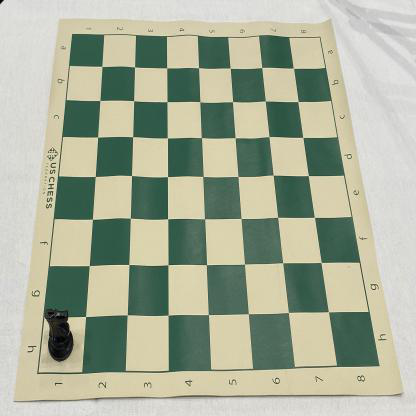

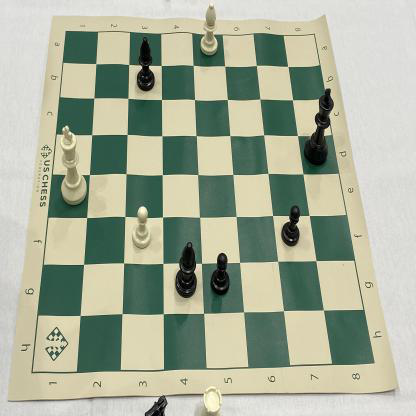

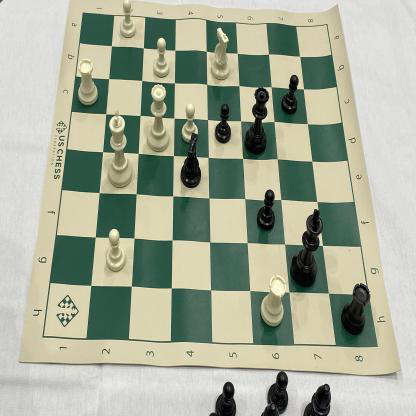

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)